<a href="https://colab.research.google.com/github/lucruzz/shakespeare-monkeys/blob/main/mutacao_recorrente_unidirecional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mutação recorrente

## Mutação recorrente unidirecional

Considere que um gene $A_{1}$, sofra uma mutação para $A_{2}$ com uma frequência $u$ por geração. Se a frequência gênica de $A_{1}$ é $p_{0}$ em uma dada geração, a  frequência dos alelos mutantes $A_{2}$ será $up_{0}$ na próxima geração. Dessa forma, a nova frequência de $A_{1}$ será $p_{0} - up_{0}$ ou ainda $p_{0}(1 - u)$.

Se prosseguirmos o cálculo das frequências nas próximas gerações, chegaremos a seguinte equação:

$p_{t} = p_{0}(1 - u)^{t}$

Onde:

- $p_{0}$ é a frequência inicial do alelo $A_{1}$
- $u$ é a taxa de mutação (proporção de $A_{1}$ que muda para $A_{2}$)
- $t$ é o número de gerações

Suponha que desejamos calcular a frequência do alelo $A_2$. Podemos considerar o fato de que a soma das frequências dos alelos $A_1$ e $A_2$ em qualquer geração deve ser igual a 1. Logo, temos:

$p_t + q_t = 1$

Onde:
- $p_t$ é a frequência do alelo $A_1$
- $q_t$ é a frequência do alelo $A_2$

Dessa forma, a partir das equações anteriores podemos obter $q_t$:

$q_t = 1 - p_t$ ou ainda $q_t = 1 - p_0(1 - u)^t$

**\* Basicamente, isso tudo quer dizer que enquanto a frequência de um aumenta o da outra diminui.**

In [ ]:
# importar as bibliotecas
import matplotlib.pyplot as plt
import numpy as np
from itertools import zip_longest

In [ ]:
def hardy_weinberg(p, q):
    p2 = p ** 2  # Frequência de A1A1
    pq = 2 * p * q  # Frequência de A1A2
    q2 = q ** 2  # Frequência de A2A2
    return (p2, pq, q2)

In [ ]:
def chi_square(obs : float, exp : float, cat : int):
  gl = cat - 1 # grau de liberdade
  #chi2 = np.sum( (obs - exp) ** 2 / exp )
  chi2 = np.sum(np.where(exp != 0, (obs - exp) ** 2 / exp, 0))
  return chi2

In [ ]:
def unidirectional_mutation_modified(p0, u, generations, n, threshold=10e-8, stability=10):
  # frequências dos alelos A1 e A2
  p_values = [p0]
  q_values = [1 - p0]
  freq_genotipos = [hardy_weinberg(p0, 1-p0)]
  chi2 = []
  categorias = len(freq_genotipos[0]) # categorias/classes seria o numero de genotipos com que estamos lidando (nesse caso 3: AA, Aa, aa)

  counter_threshold = 0 # contador para limite do qui-quadrado atingido
  stable = -1
  ehw_reached = False

  for t in range(1, generations):
    # calcula a frequência de A1 na próxima geração
    p_next = p0 * (1 - u) ** t
    q_next = 1 - p_next  # frequência de A2
    p_values.append(p_next)
    q_values.append(q_next)
    freq_genotipos.append( hardy_weinberg(p_next, q_next) )

    # pego os valores observados das frequencias genotípicas da geração passada com base em uma populaçao de tamanho n
    freq_observed = np.array([freq_genotipos[-2][0], freq_genotipos[-2][1], freq_genotipos[-2][2]])
    observed = np.array([freq_genotipos[-2][0], freq_genotipos[-2][1], freq_genotipos[-2][2]]) * n

    # com base na mutação que acabou de ocorrer, calculo as frequencias genotípicas esperadas com base em uma populaçao de tamanho n
    freq_expected = np.array(hardy_weinberg(p_next, q_next))
    expected = np.array(hardy_weinberg(p_next, q_next)) * n

    qui = chi_square(obs=observed, exp=expected, cat=categorias)
    chi2.append(qui)

    if (qui < threshold and not ehw_reached):
      counter_threshold += 1
      if counter_threshold >= stability: # se o contador passar do limite estabelecido então assumo que tá em equilíbrio
        print(f'Simulação de p0 = {p0} atingiu EHW na geração {t}.')
        stable = t
        ehw_reached = True
        # break

  return p_values, q_values, freq_genotipos, chi2, stable

In [ ]:
def unidirectional_mutation(p0, u, generations, n):
  # frequências dos alelos A1 e A2
  p_values = [p0]
  q_values = [1 - p0]
  freq_genotipos = [hardy_weinberg(p0, 1-p0)]
  chi2 = []
  categorias = len(freq_genotipos[0]) # categorias/classes seria o numero de genotipos com que estamos lidando (nesse caso 3: AA, Aa, aa)

  for t in range(1, generations):
    # calcula a frequência de A1 na próxima geração
    p_next = p0 * (1 - u) ** t
    q_next = 1 - p_next  # frequência de A2
    p_values.append(p_next)
    q_values.append(q_next)
    freq_genotipos.append( hardy_weinberg(p_next, q_next) )

    # pego os valores observados das frequencias genotípicas da geração passada com base em uma populaçao de tamanho n
    freq_observed = np.array([freq_genotipos[-2][0], freq_genotipos[-2][1], freq_genotipos[-2][2]])
    observed = np.array([freq_genotipos[-2][0], freq_genotipos[-2][1], freq_genotipos[-2][2]]) * n

    # com base na mutação que acabou de ocorrer, calculo as frequencias genotípicas esperadas com base em uma populaçao de tamanho n
    freq_expected = np.array(hardy_weinberg(p_next, q_next))
    expected = np.array(hardy_weinberg(p_next, q_next)) * n

    qui = chi_square(obs=observed, exp=expected, cat=categorias)
    chi2.append(qui)

  return p_values, q_values, freq_genotipos, chi2

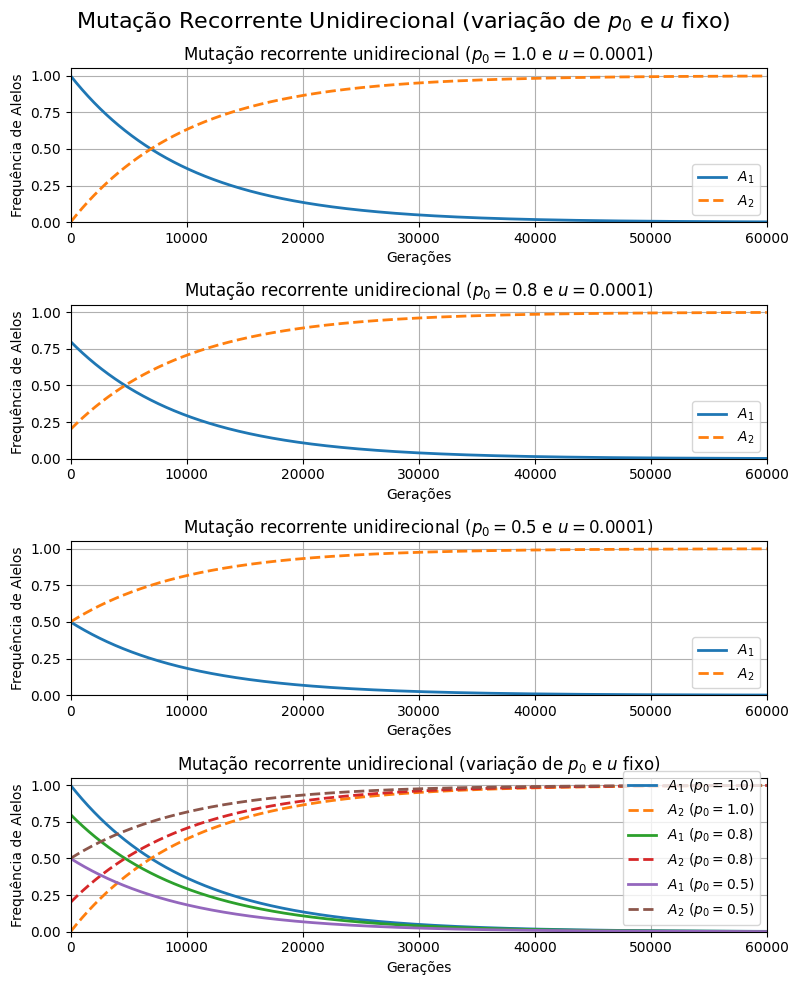

In [ ]:
p0_values = [1.0, 0.8, 0.5]
u = 1.0e-4  # taxa de mutação
generations = 60000  # número de gerações
n = 1000 # supondo uma população de n indivíduos

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 10))

fig.suptitle('Mutação Recorrente Unidirecional (variação de $p_0$ e $u$ fixo)', fontsize=16)

for (i, p0, ax) in zip(range(3), p0_values, [ax1, ax2, ax3]):
    freq_alelo_dominante, freq_alelo_recessivo, _, _ = unidirectional_mutation(p0, u, generations, n)

    # plot genótipos
    ax4.plot(freq_alelo_dominante, label=f'$A_1$ ($p_0 = {p0}$)', linewidth=2)
    ax4.plot(freq_alelo_recessivo, label=f'$A_2$ ($p_0 = {p0}$)', linestyle='--', linewidth=2)

    # plot genótipos
    ax.plot(freq_alelo_dominante, label=f'$A_1$', linewidth=2)
    ax.plot(freq_alelo_recessivo, label=f'$A_2$', linestyle='--', linewidth=2)

for (ax, p0) in zip_longest([ax1, ax2, ax3, ax4], p0_values, fillvalue=None):
  if (ax == ax4):
    ax4.set_title(f'Mutação recorrente unidirecional (variação de $p_0$ e $u$ fixo)')
  else:
    ax.set_title(f'Mutação recorrente unidirecional ($p_0 = {p0}$ e $u = {u}$)')
  ax.set_xlabel('Gerações')
  ax.set_ylabel('Frequência de Alelos')
  ax.set_xlim(0, generations)
  ax.set_ylim(0, 1.05)
  ax.grid(True)
  #ax.legend()
  ax.legend(loc='lower right')

# plot
plt.tight_layout() # tira sobreposição
plt.show()

## ALTERANDO A TAXA DE MUTAÇÃO

O esperado é que quanto menor for a taxa de mutação ($u$), a variação na frequência alélica aconteça mais lentamente ao longo das gerações. E, por outro lado, quanto mais alta a taxa de mutação ($u$), a evolução na frequência acontece de forma mais rápida, precisando de menos gerações para encontrar um ponto de "estagnação".

### TESTE DO QUI-QUADRADO

**Valores observados:** Seriam as frequências genotípicas da geração anterior, ou seja, o que a população realmente apresentou antes da mutação.

**Valores esperados:** Seriam baseados nas novas frequências de alelos após a mutação ocorrer, calculados para a geração atual.

<ipython-input-115-4bc8ef5f67ed>:4: RuntimeWarning: invalid value encountered in divide
  chi2 = np.sum(np.where(exp != 0, (obs - exp) ** 2 / exp, 0))


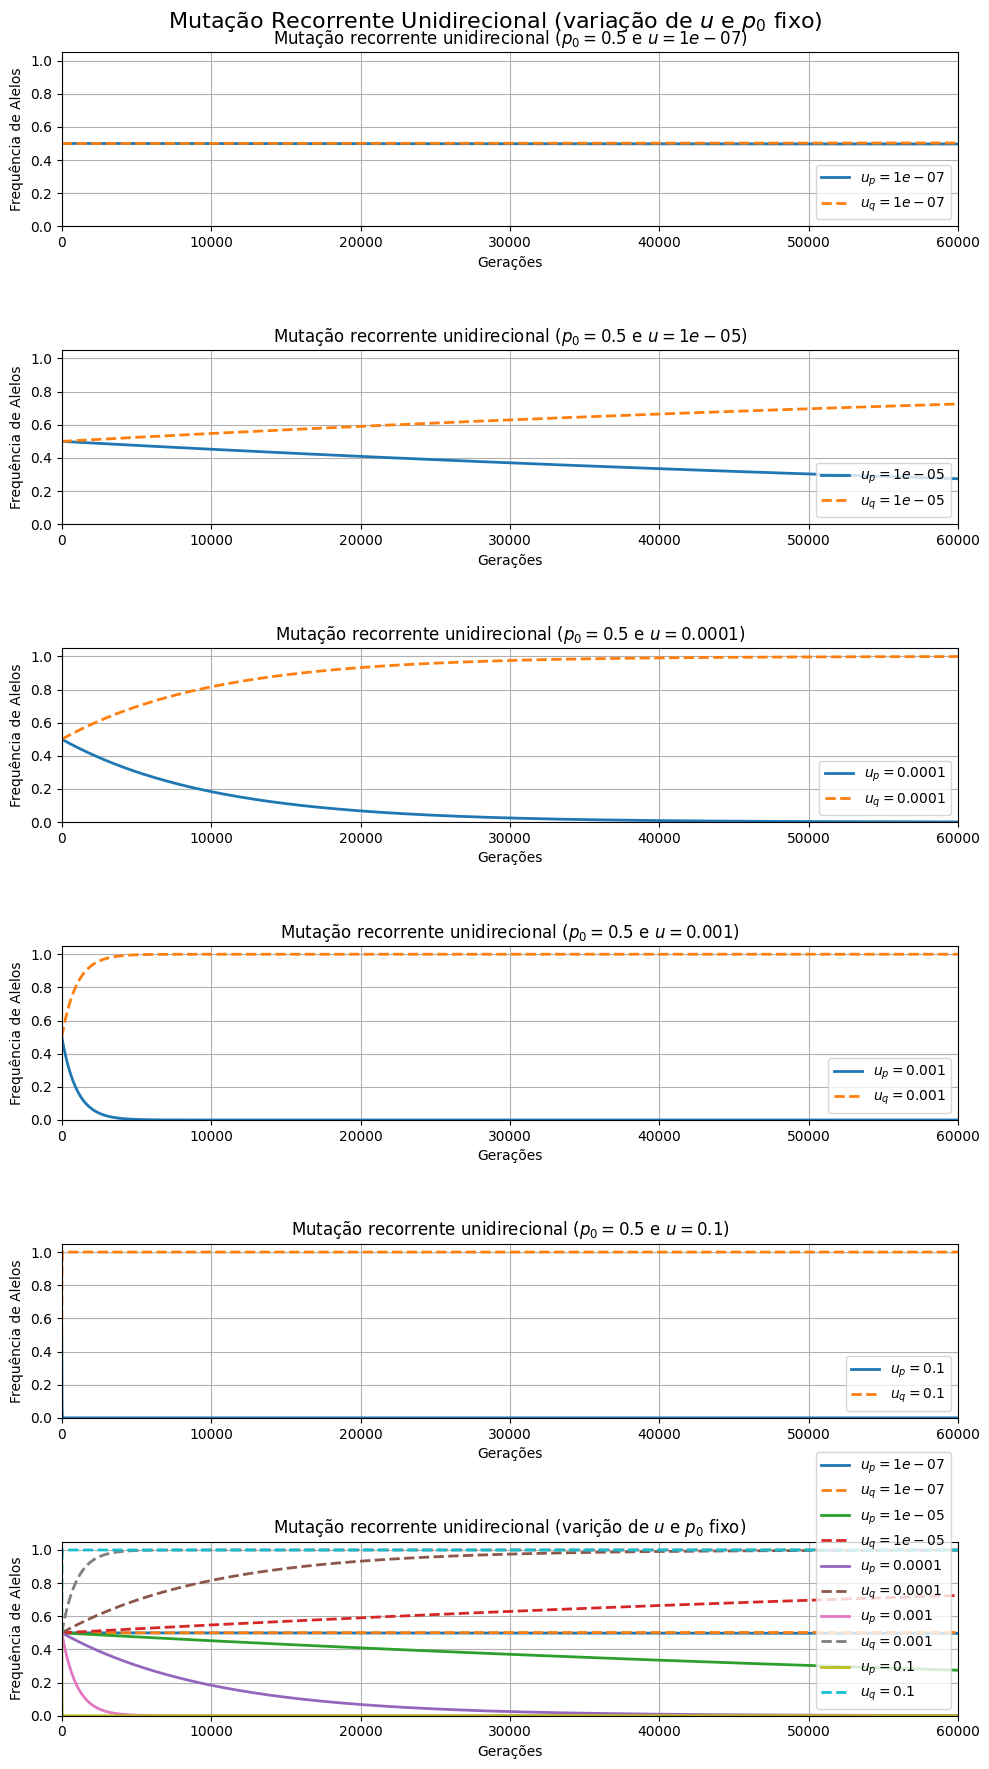

In [ ]:
p0 = 0.5
u_list = [1.0e-7, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-1]  # lista de taxa de mutação
generations = 60000  # número de geracoes
n = 1000 # supondo uma população de n indivíduos

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(10, 18))

fig.suptitle('Mutação Recorrente Unidirecional (variação de $u$ e $p_0$ fixo)', fontsize=16)

for (i, u, ax) in zip(range(5), u_list, [ax1, ax2, ax3, ax4, ax5]):
    p, q, _, _ = unidirectional_mutation(p0, u, generations, n)

    # plot todos os genótipos
    ax6.plot(p, label=f'$u_p = {u}$', linewidth=2)
    ax6.plot(q, label=f'$u_q = {u}$', linestyle='--', linewidth=2)

    # plots individuais dos genótipos
    ax.plot(p, label=f'$u_p = {u}$', linewidth=2)
    ax.plot(q, label=f'$u_q = {u}$', linestyle='--', linewidth=2)

for (ax, u) in zip_longest([ax1, ax2, ax3, ax4, ax5, ax6], u_list, fillvalue=None):
  if (ax == ax6):
    ax6.set_title(f'Mutação recorrente unidirecional (varição de $u$ e $p_0$ fixo)')
  else:
    ax.set_title(f'Mutação recorrente unidirecional ($p_0 = {p0}$ e $u = {u}$)')
  ax.set_xlabel('Gerações')
  ax.set_ylabel('Frequência de Alelos')
  ax.set_xlim(0, generations)
  ax.set_ylim(0, 1.05)
  ax.grid(True)
  #ax.legend()
  ax.legend(loc='lower right')

# plot
plt.tight_layout() # tira sobreposição
#plt.subplots_adjust(top=0.92, hspace=1.5)
plt.show()

Simulação de p0 = 1.0 atingiu EHW na geração 53042.
Simulação de p0 = 0.8 atingiu EHW na geração 50811.
Simulação de p0 = 0.5 atingiu EHW na geração 46111.


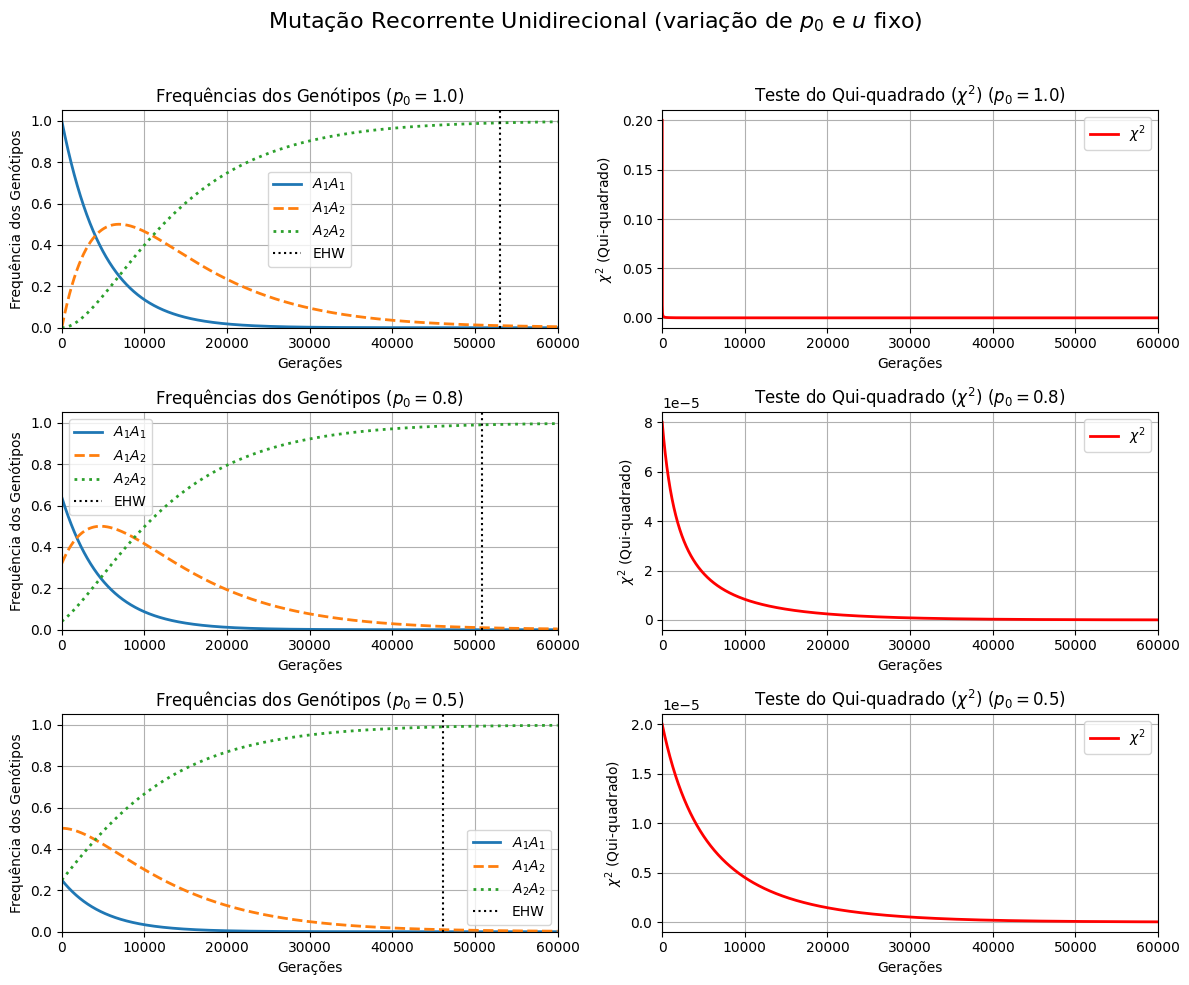

In [ ]:
p0_values = [1.0, 0.8, 0.5]
u = 1.0e-4  # taxa de mutação
generations = 60000  # número de gerações
n = 1000  # supondo uma população de n indivíduos

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

fig.suptitle('Mutação Recorrente Unidirecional (variação de $p_0$ e $u$ fixo)', fontsize=16)

for i, p0 in enumerate(p0_values):
    _, _, freq_genotipica, chi2, stable_gen = unidirectional_mutation_modified(p0, u, generations, n, stability=10)

    freq_AA = [gen[0] for gen in freq_genotipica]
    freq_AB = [gen[1] for gen in freq_genotipica]
    freq_BB = [gen[2] for gen in freq_genotipica]

    # subplot das frequências genotípicas do lado esquerdo
    axs[i, 0].plot(freq_AA, label=f'$A_1A_1$', linewidth=2)
    axs[i, 0].plot(freq_AB, label=f'$A_1A_2$', linestyle='--', linewidth=2)
    axs[i, 0].plot(freq_BB, label=f'$A_2A_2$', linestyle=':', linewidth=2)

    axs[i, 0].set_title(f'Frequências dos Genótipos ($p_0 = {p0}$)')
    axs[i, 0].set_xlabel('Gerações')
    axs[i, 0].set_ylabel('Frequência dos Genótipos')
    axs[i, 0].set_xlim(0, generations)
    axs[i, 0].set_ylim(0, 1.05)
    axs[i, 0].grid(True)
    axs[i, 0].legend(loc='lower right')

    # subplot da qui-quadrado do lado direito
    axs[i, 1].plot(chi2, label=f'$\chi^2$', color='r', linewidth=2)

    axs[i, 1].set_title(f'Teste do Qui-quadrado ($\chi^2$) ($p_0 = {p0}$)')
    axs[i, 1].set_xlabel('Gerações')
    axs[i, 1].set_ylabel('$\chi^2$ (Qui-quadrado)')
    axs[i, 1].set_xlim(0, generations)
    axs[i, 1].grid(True)
    axs[i, 1].legend(loc='upper right')

    #axs[i, 0].scatter(stable_gen, chi2[stable_gen], color='blue', s=100, zorder=5)
    axs[i, 0].axvline(x=stable_gen, color='black', zorder=5, linestyle=':', label='EHW')
    axs[i, 0].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
